In [ ]:
"""
Written and maintained by Andreas Mentzelopoulos
Copyright (c) 2025, Andreas Mentzelopoulos. All Rights Reserved.

This code is the exclusive property of Andreas Mentzelopoulos
All associated materials (data, models, scripts) are the
exclusive property of Andreas Mentzelopoulos and LOBSTgER.

No part of this code may be copied, distributed, modified, or used in any
form without the prior written consent of Andreas Mentzelopoulos.

For permission requests, contact: Andreas Mentzelopoulos, ament@mit.edu.
"""

In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from helpers.read_data_tools import read_data, imageDataset, latentDataset, build_latentDataset, load_latentDataset, load_imageDataset
from helpers.train_utils import read_checkpoint, clean, print_training_logs, write_checkpoint, update_ema, flat_then_decay_w_warmup, update_dataloader
from helpers.pre_trained_autoencoder import load_autoencoder
from helpers.diffusion_utils_conditional import forward_sample, cosine_beta_schedule, sample_t
from helpers.artificial_corruption_utils import corrupt_fast
from model_architectures import UnconditionalUNet, ConditionalUNet

In [3]:
'''
## If you don't store latentDataset and have to read over again
H, W = 512, 768 ## Resolution to resize images
train_images, train_labels = read_data(H = H, W = W, no_split = True)
autoencoder = load_autoencoder(half_precision = True)

train_imageDataset = imageDataset(train_images, train_labels)
train_latentDataset = build_latentDataset(ImageDataset = train_imageDataset, autoencoder = autoencoder, batch_size = 32)
train_loader = DataLoader(train_latentDataset, batch_size = 64, shuffle = True)
'''

'''
train_latentDataset = load_latentDataset()
train_loader = DataLoader(train_latentDataset, batch_size = 64, shuffle = True)
'''

Loading Rest: 100%|██████████| 1992/1992 [02:11<00:00, 15.11it/s]


No images found


Batch encoding for training dataset: 100%|██████████| 78/78 [07:35<00:00,  5.84s/it]


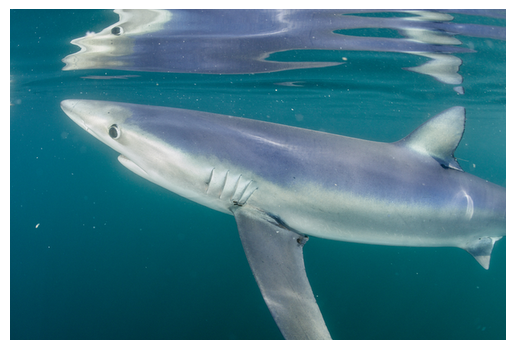

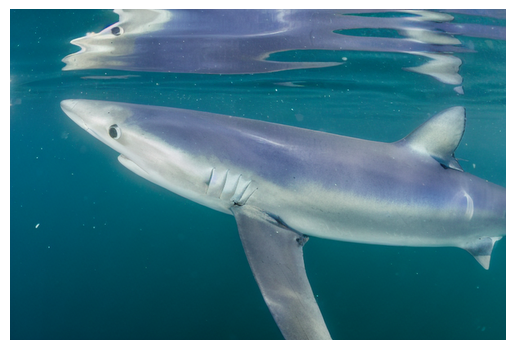

In [36]:
from helpers.plotting_utils import plot_image
from helpers.pre_trained_autoencoder import encode, decode 
autoencoder = load_autoencoder(half_precision = True)

index = torch.randint(len(train_imageDataset), (1,))

plot_image(train_imageDataset.images[index])
plot_image(decode(autoencoder = autoencoder, z = train_loader.dataset.raw_latents[index]))


In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
autoencoder = load_autoencoder(half_precision = True)

## Diffusion hyperparameters
num_epochs = 1000       # Number of training epochs
total_timesteps = 1000   # Number of diffusion timesteps
learning_rate = 1e-2     # Learning rate
beta_t = cosine_beta_schedule(total_timesteps) # Variance Schedule, cosine or linear
cfg_dropout = 0.25       # Dropout for classifier free guidance
ema_decay = 0.995        # EMA decay
mixed_precision = True   # Mixed precision 

## Checkpoint
log_every = 5
checkpoint_every = 100 # epochs

## Dataloader augmentation refreshing
refresh_dataloader = True
refresh_dataloader_every = 10 # epochs
refresh_number = 200

# Create the Unet model
model = ConditionalUNet(dim = 128, dim_mults = (1,2,), beta_t = beta_t, timesteps = total_timesteps).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = flat_then_decay_w_warmup(optimizer = optimizer, num_epochs = num_epochs, flat_until = 0.4, warmup_steps = 100)
scaler = GradScaler()

## Load the training images
train_imageDataset = load_imageDataset()
print(f"Loaded {len(train_imageDataset)} train_images.")


epoch_start, ema_params, losses_total, train_loader = read_checkpoint(model = model, optimizer = optimizer, scaler = scaler, scheduler = scheduler)
print(f"Resuming at epoch: {epoch_start}") 


Loaded 2472 train_images.
Loaded train_loader
Model number of parameters: 11766444
Resuming at epoch: -1


In [3]:
# Training Loop

model.train()
clean()
for epoch in tqdm(range(epoch_start+1, num_epochs)):
    
    train_losses = []
    for i, (batch_conditions, batch_targets, batch_classes) in enumerate(train_loader):

        batch_conditions = batch_conditions.half().to(device)
        batch_targets = batch_targets.half().to(device)
        #batch_classes = batch_classes.to(device)
        #print(batch_conditions.shape)
        #print(batch_conditions.dtype)
        
        e = torch.randn_like(batch_targets)
        t = sample_t(bad_data = True, TOTAL_TIMESTEPS = total_timesteps, batch_targets = batch_targets, batch_classes = batch_classes)
        x_t, v_t = forward_sample(x_0 = batch_targets, t=t, e=e, alphas_cumprod = model.alphas_cumprod) # Calculates velocity

        # set to null token for unconditional model
        rand_ind = torch.randperm(batch_conditions.shape[0])[:int(cfg_dropout * batch_conditions.shape[0])]
        batch_conditions[rand_ind] = model.class_tokens.to(dtype = batch_conditions.dtype)

        optimizer.zero_grad(set_to_none=True)

        if mixed_precision:
            with torch.cuda.amp.autocast():
                v_pred = model(x_t, batch_conditions, t)
                loss = torch.nn.functional.mse_loss(v_t, v_pred)
             
            if torch.isnan(loss): # If crash   
                optimizer.zero_grad(set_to_none=True)
                continue
                
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

        else:
            v_pred = model(x_t, batch_conditions, t)
            loss = F.mse_loss(v_t, v_pred)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        if epoch > 10:
            update_ema(model = model, ema_params = ema_params, ema_decay = ema_decay)
        train_losses.append(loss.item())  # Store the original loss

    if scheduler:
        scheduler.step()
    losses_total.append(np.mean(train_losses))
    
    ## User Logs
    if (epoch+1) % log_every == 0:
        print(f"Epoch: {epoch+1} Train Loss: {np.mean(train_losses)}")
        print_training_logs(epoch = epoch, losses_total = losses_total, optimizer = optimizer)

    ## Write Checkpoint
    if (epoch+1) % checkpoint_every == 0 and epoch != 0:
        ## Need to update the name of saved model
        write_checkpoint(epoch = epoch, model = model, optimizer = optimizer, scaler = scaler, ema_params = ema_params, losses_total = losses_total, train_loader = train_loader,
                   scheduler = scheduler)

    if refresh_dataloader and (epoch + 1) % refresh_dataloader_every == 0 and epoch != 0:
        train_loader =  update_dataloader(train_loader = train_loader, train_imageDataset = train_imageDataset, autoencoder = autoencoder, N = refresh_number)
            
        #sample_and_save_images(model, epoch+1, num_samples=10, channels=4)
        #print(f"Generated samples at epoch: {epoch+1}")

    if (epoch+1) % 100 == 0 and epoch != 0:
        #update_dataloader(train_loader)
        #train_loader = renew_dataloader()
        clean()

  0%|          | 0/1000 [00:21<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.13 GiB (GPU 0; 31.50 GiB total capacity; 13.39 GiB already allocated; 1.08 GiB free; 13.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [4]:
write_checkpoint(epoch = epoch, model = model, optimizer = optimizer, scaler = scaler, ema_params = ema_params, losses_total = losses_total, train_loader = train_loader,
                   scheduler = scheduler)

Model saved, epoch: 290
